<a href="https://colab.research.google.com/github/KubaWinsztal/MachineLearning/blob/main/PD9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install --upgrade --force-reinstall torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156

**CODE FROM CLASS**


In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt


# reading MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

# mean and std of dataset
mean_dataset = trainset.data.numpy().mean()/255.0
std_dataset = trainset.data.numpy().std()/255.0

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((mean_dataset), (std_dataset))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)


class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()

        # Define all layers explicitly
        self.linear1 = torch.nn.Linear(1*28*28, 1024)  # First linear layer
        self.linear2 = torch.nn.Linear(1024, 2048)     # Second linear layer
        self.linear3 = torch.nn.Linear(2048, 256)      # Third linear layer
        self.linear4 = torch.nn.Linear(256, 10)        # Final linear layer (no activation)

        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):      # Input shape: (B, 1, 28, 28)
        x = self.flatten(x)    # Shape: (B, 784)

        # Pass through all layers with ReLU activation
        x = self.relu(self.linear1(x))  # Shape: (B, 1024)
        x = self.relu(self.linear2(x))  # Shape: (B, 2048)
        x = self.relu(self.linear3(x))  # Shape: (B, 256)
        x = self.linear4(x)             # Shape: (B, 10) - no activation

        x = self.dropout(x)
        return x



# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

100%|██████████| 9.91M/9.91M [00:00<00:00, 95.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 26.1MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 84.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.21MB/s]


Working on cpu
epoch: 0 batch: 0 current batch loss: 2.3054862022399902
epoch: 0 batch: 1 current batch loss: 2.0760021209716797
epoch: 0 batch: 2 current batch loss: 1.6668649911880493
epoch: 0 batch: 3 current batch loss: 1.1472059488296509
epoch: 0 batch: 4 current batch loss: 0.9818516373634338
epoch: 0 batch: 5 current batch loss: 1.1621983051300049
epoch: 0 batch: 6 current batch loss: 1.0923999547958374
epoch: 0 batch: 7 current batch loss: 0.8581209182739258
epoch: 0 batch: 8 current batch loss: 0.7413910031318665
epoch: 0 batch: 9 current batch loss: 0.6122564077377319
epoch: 0 batch: 10 current batch loss: 0.6393547058105469
epoch: 0 batch: 11 current batch loss: 0.6141698956489563
epoch: 0 batch: 12 current batch loss: 0.5738203525543213
epoch: 0 batch: 13 current batch loss: 0.4798968434333801
epoch: 0 batch: 14 current batch loss: 0.4433319866657257
epoch: 0 batch: 15 current batch loss: 0.495651513338089
epoch: 0 batch: 16 current batch loss: 0.5028749704360962
epoch: 0 b

In [2]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9795


TASK 1

Step 0, Loss: 3.8057, Confidence: [0.02522549033164978, 0.011530797928571701, 0.37961921095848083, 0.017798500135540962, 0.007981844246387482, 0.4371253252029419, 0.005641562398523092, 0.6797985434532166, 0.0012911998201161623, 0.0008732358692213893]
Step 100, Loss: 0.0010, Confidence: [0.9990283250808716, 0.9985792636871338, 0.9996609687805176, 0.9993670582771301, 0.9995993971824646, 0.9995149374008179, 0.999006450176239, 0.9998366832733154, 0.9981650710105896, 0.9973965883255005]
Step 200, Loss: 0.0007, Confidence: [0.9993107318878174, 0.9991453886032104, 0.999760091304779, 0.9995033740997314, 0.9996633529663086, 0.9996795654296875, 0.9992673993110657, 0.9998788833618164, 0.9986763596534729, 0.9981289505958557]
Step 300, Loss: 0.0005, Confidence: [0.9994999170303345, 0.9994186162948608, 0.9998258948326111, 0.999617338180542, 0.9997178912162781, 0.999776303768158, 0.9994547963142395, 0.9999086856842041, 0.9990108013153076, 0.9986165761947632]
Step 400, Loss: 0.0004, Confidence: [0.999

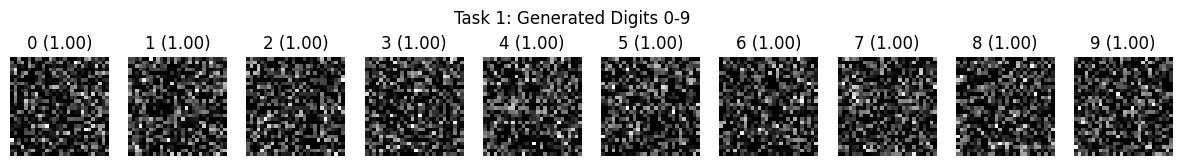

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Ensure the network is in evaluation mode
net.eval()

# Mean and std from the dataset for denormalization
mean = mean_dataset
std = std_dataset

# Generate initial Gaussian noise (10 images)
dreamed_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)
target_classes = torch.arange(10, device=device)  # Each image targets a unique class 0-9

# Optimizer setup (only optimizes the input images)
optimizer = torch.optim.Adam([dreamed_inputs], lr=0.01)

# Training loop to optimize inputs
for step in range(1000):
    optimizer.zero_grad()
    logits = net(dreamed_inputs)
    loss = F.cross_entropy(logits, target_classes)
    loss.backward()
    optimizer.step()

    # Logging
    if step % 100 == 0 or step == 999:
        with torch.no_grad():
            probs = F.softmax(logits, dim=1)
            max_probs = probs[torch.arange(10), target_classes]
            print(f"Step {step}, Loss: {loss.item():.4f}, Confidence: {max_probs.tolist()}")

# Denormalize and visualize
dreamed_images = dreamed_inputs.detach().cpu()
dreamed_images = dreamed_images * std + mean  # Denormalize
dreamed_images = dreamed_images.clamp(0, 1)   # Clamp to valid pixel range

fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axs[i].imshow(dreamed_images[i][0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"{i} ({max_probs[i].item():.2f})")
plt.suptitle("Task 1: Generated Digits 0-9")
plt.show()

**Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?**

The generated images do not resemble real MNIST digits. Here’s why:

1. **Network-Centric Optimization, Not Human Perception**  
   The optimization process modifies the input to maximize the network’s confidence for a target class, not to mimic human-recognizable digits. Neural networks learn abstract, hierarchical features (e.g., edges, textures) rather than holistic shapes. The generated images exploit these learned features, creating patterns that activate the target class’s neurons but lack coherent visual structure to humans.

2. **Adversarial Nature of the Process**  
   The generated images are effectively adversarial examples. They achieve high confidence by exploiting the network’s decision boundaries, often using high-frequency noise or non-semantic pixel arrangements that are imperceptible or meaningless to humans but statistically significant to the model.

3. **Missing Constraints**  
   Real MNIST digits follow specific conventions (centered strokes, consistent thickness, etc.). The optimization process lacks:  
   - **Inductive biases:** No constraints enforce stroke-like structures or spatial coherence.  
   - **Data distribution alignment:** The loss function (cross-entropy) does not penalize deviations from the MNIST data distribution.

4. **Theoretical Explanation**  
   Neural networks map inputs to a high-dimensional feature space where classes are separable. The optimization navigates this space to find inputs that lie in the target class’s region, but these inputs need not lie in the manifold of real-world digit images.


TASK 2

Step 0, Loss: 1.130016803741455
Step 100, Loss: 0.6941163539886475
Step 200, Loss: 0.6936848163604736
Step 300, Loss: 0.6934866309165955
Step 400, Loss: 0.6933906674385071
Step 500, Loss: 0.693348228931427
Step 600, Loss: 0.6932958364486694
Step 700, Loss: 0.6932711601257324
Step 800, Loss: 0.6932506561279297
Step 900, Loss: 0.6932365894317627


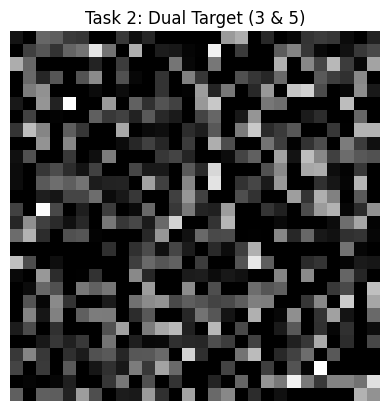

Probabilities for 3: 0.500, 5: 0.500


In [4]:
# Target two classes (e.g., 3 and 5)
target1 = 3
target2 = 5

# Initialize a single noise image
dual_input = torch.randn((1, 1, 28, 28), device=device, requires_grad=True)
optimizer_dual = torch.optim.Adam([dual_input], lr=0.01)

# Optimization loop
for step in range(1000):
    optimizer_dual.zero_grad()
    logits = net(dual_input)
    loss = (F.cross_entropy(logits, torch.tensor([target1], device=device)) +
            F.cross_entropy(logits, torch.tensor([target2], device=device))) / 2
    loss.backward()
    optimizer_dual.step()

    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.item()}")

# Denormalize and visualize
dual_image = dual_input.detach().cpu()
dual_image = dual_image * std + mean
dual_image = dual_image.clamp(0, 1)

plt.imshow(dual_image[0][0], cmap='gray')
plt.axis('off')
plt.title(f"Task 2: Dual Target ({target1} & {target2})")
plt.show()

# Check probabilities
with torch.no_grad():
    probs = F.softmax(net(dual_input), dim=1).squeeze()
    print(f"Probabilities for {target1}: {probs[target1].item():.3f}, {target2}: {probs[target2].item():.3f}")

**Answer to Task 2 Discussion and Results:**

### **Approach to Generating Multi-Class Images**  
To create an image that the network associates with two digits (e.g., 3 and 5), we optimize the input to **maximize the probabilities for both classes simultaneously**. Here’s the methodology:

1. **Loss Function Design**:  
   - Use a **combined loss** that averages the cross-entropy losses for both target classes.  
   - Formula:  
$$
\text{Loss} = \frac{1}{2} \left( \text{CE}(y_{\text{pred}}, y_{\text{target}=3}) + \text{CE}(y_{\text{pred}}, y_{\text{target}=5}) \right)
$$  
     This forces the network to balance confidence between the two classes.

2. **Optimization Process**:  
   - Start with Gaussian noise as the initial input.  
   - Use gradient descent to iteratively update the input pixels, minimizing the combined loss.  

3. **Key Insight**:  
   The network’s feature space allows inputs to activate neurons for multiple classes, even if the resulting image lacks human-interpretable structure.

TASK 3

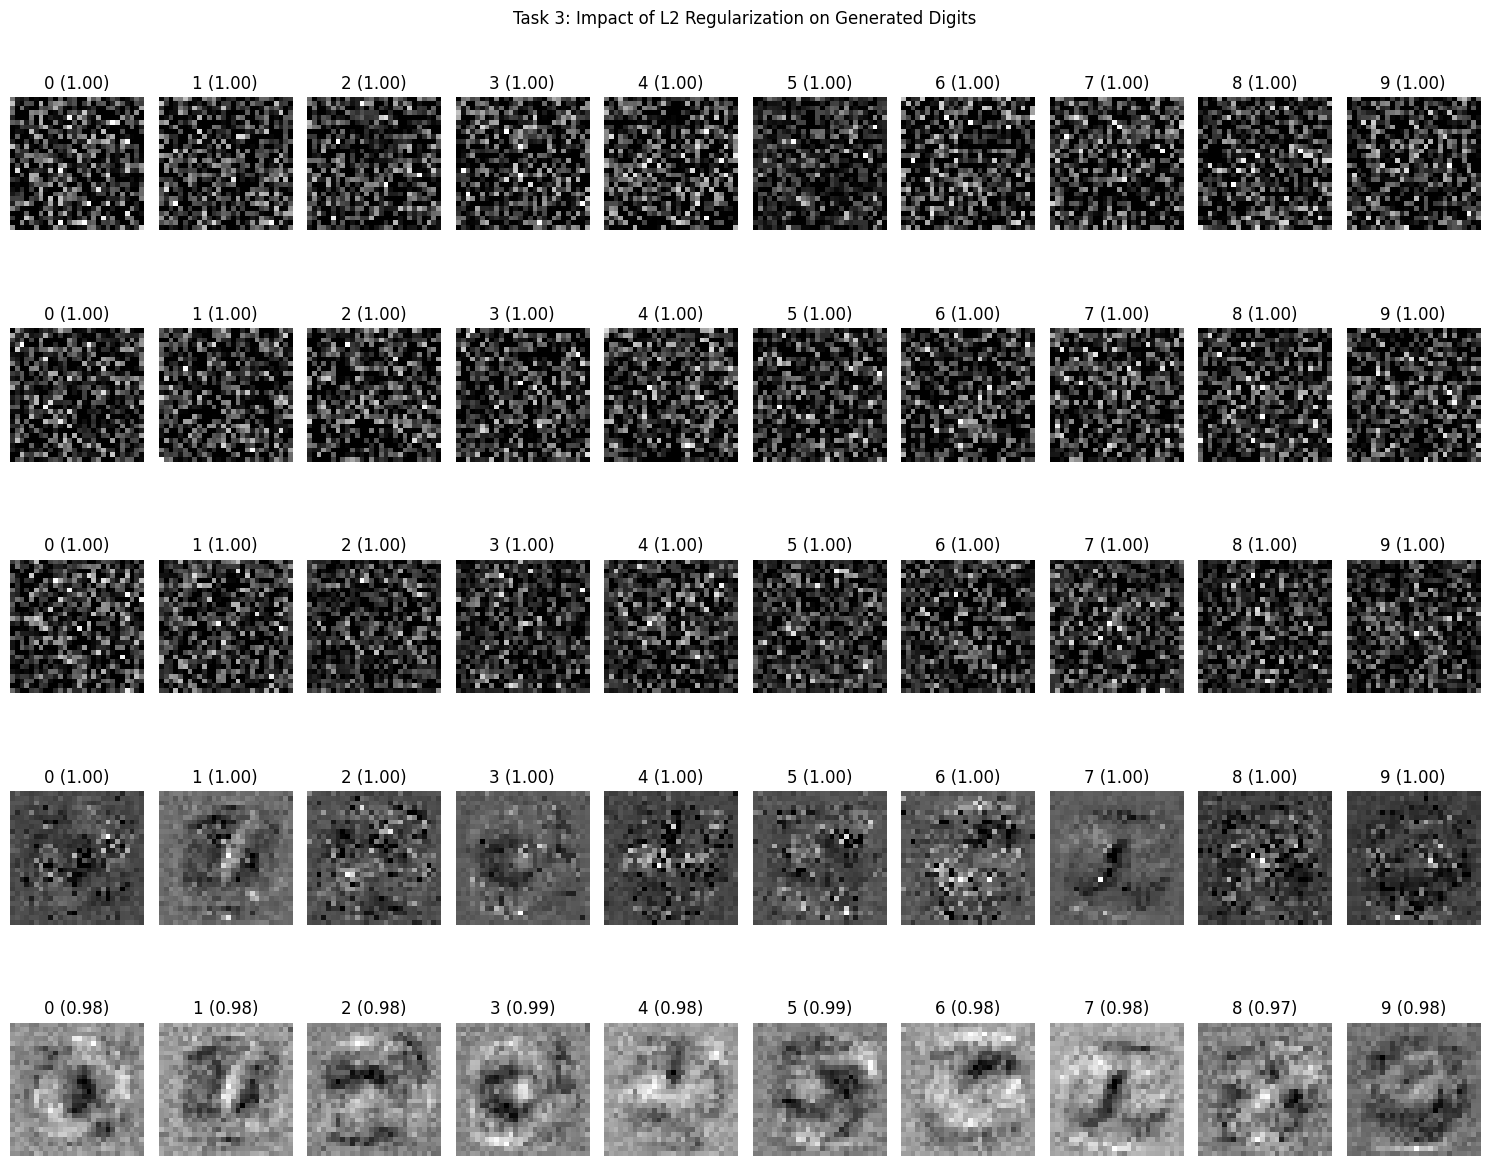

In [5]:
lambda_l2_values = [0.001, 0.01, 0.1, 1.0, 10.0]
results = []

for lambda_l2 in lambda_l2_values:
    # Reinitialize inputs for each lambda
    dreamed_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)
    optimizer = torch.optim.Adam([dreamed_inputs], lr=0.01)

    for step in range(1000):
        optimizer.zero_grad()
        logits = net(dreamed_inputs)
        loss = F.cross_entropy(logits, target_classes) + lambda_l2 * dreamed_inputs.pow(2).mean()
        loss.backward()
        optimizer.step()

    # Store results
    with torch.no_grad():
        probs = F.softmax(logits, dim=1)
        max_probs = probs[torch.arange(10), target_classes]
        images = dreamed_inputs.detach().cpu() * std + mean
        images = images.clamp(0, 1)
        results.append((lambda_l2, images, max_probs))

# Visualize results
fig, axs = plt.subplots(len(lambda_l2_values), 10, figsize=(15, 2.5*len(lambda_l2_values)))
for row, (lambda_l2, images, probs) in enumerate(results):
    for col in range(10):
        axs[row, col].imshow(images[col][0], cmap='gray')
        axs[row, col].set_title(f"{col} ({probs[col].item():.2f})")
        axs[row, col].axis('off')
    axs[row, 0].set_ylabel(f"λ={lambda_l2}", rotation=0, labelpad=40)
plt.suptitle("Task 3: Impact of L2 Regularization on Generated Digits")
plt.tight_layout()
plt.show()

**Answer to Task 3: Impact of L2 Regularization**

### **Observations and Analysis**  
1. **Recognition Accuracy**:  
   - **Low λ (0.001–0.01)**: The network still recognizes digits with high confidence. The L2 penalty is too weak to significantly alter the adversarial optimization process.  
   - **Moderate λ (0.1–1.0)**: Generated images become smoother, with reduced noise. Recognition confidence slightly decreases but remains acceptable, as the L2 term suppresses extreme pixel values without erasing critical features.  
   - **High λ (10.0)**: Over-regularization occurs. Images turn blurry/oversimplified, and confidence drops sharply. The L2 penalty dominates, suppressing pixel intensities essential for class-specific activations.  

2. **Digit Quality**:  
   - **Low λ**: Images resemble Task 1 outputs (noisy, non-human-readable).  
   - **Moderate λ**: Noise is reduced, and faint digit-like structures emerge (e.g., strokes). Images are closer to MNIST aesthetics but still lack fine details.  
   - **High λ**: Images become overly smooth/blobby, losing discriminative features (e.g., edges).  

---

### **Key Trade-off**  
The L2 penalty acts as a **regularizer**, trading off between:  
- **Noise suppression** (improved visual quality) and  
- **Feature preservation** (maintaining network confidence).  


### **Conclusion**  
- **L2 regularization improves visual quality** but **reduces network confidence** at higher strengths.  
- Optimal λ balances noise reduction and feature retention
- The penalty does **not guarantee human-readable digits** but shifts inputs toward the natural image manifold.  